In [1]:
from shell.datasets.datasets import get_dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from shell.utils.utils import seed_everything, viz_embedding
import torch
import subprocess
import torch.nn as nn
import torch
import os
from omegaconf import DictConfig
from shell.datasets.datasets import get_dataset
from shell.utils.utils import seed_everything
from pprint import pprint
from shell.fleet.network import TopologyGenerator
from shell.models.cnn_soft_lifelong_dynamic import CNNSoftLLDynamic
from shell.models.cnn import CNN
from shell.models.mlp import MLP
from shell.models.mlp_soft_lifelong_dynamic import MLPSoftLLDynamic
from shell.learners.er_dynamic import CompositionalDynamicER
from shell.learners.er_nocomponents import NoComponentsER
from shell.utils.experiment_utils import eval_net
from shell.utils.experiment_utils import setup_experiment
from sklearn.manifold import TSNE
import logging
import seaborn as sns
from shell.fleet.data_fleet import least_confidence_scorer, entropy_scorer, margin_scorer, cross_entropy_scorer
logging.basicConfig(level=logging.INFO)

In [12]:
data_cfg = {
    # "dataset_name": "kmnist",
    "dataset_name": "fashionmnist",
    "num_tasks": 1,
    "num_train_per_task": 128,
    "num_val_per_task": 102,
    "labels": np.array([1, 2]),
    'remap_labels': True,
}
dataset = get_dataset(**data_cfg)

task_id = 0
testloaders = {task: torch.utils.data.DataLoader(testset,
                                                 batch_size=128,
                                                 shuffle=False,
                                                 num_workers=0,
                                                 pin_memory=True,
                                                 ) for task, testset in enumerate(dataset.testset[:(task_id+1)])}

trainloader = torch.utils.data.DataLoader(dataset.trainset[task_id],
                                            batch_size=64,
                                            shuffle=True,
                                            num_workers=0,
                                            pin_memory=True,
                                            )

valset = dataset.valset[task_id]

INFO:root:Class sequence: [1 2]
INFO:root:(128, 1, 28, 28)


In [13]:
net_cfg = {
    'depth': 2,
    'layer_size': 64,
    'num_init_tasks': -1,
    'i_size': 28,
    'num_classes': 2,
    'num_tasks': 1,
    'dropout': 0.0,
}

agent_cfg = {
    'memory_size': 64,
    'use_contrastive': True,
}
net = MLP(**net_cfg)
agent = NoComponentsER(net, **agent_cfg)

agent.train(trainloader, task_id=0, num_epochs=100, testloaders=testloaders,
                save_freq=1,
                train_mode='both')

INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 6.248	acc: 0.500
INFO:root:	task: avg	loss: 6.248	acc: 0.500
INFO:root:epochs: 1, training task: 0
INFO:root:	task: 0	loss: 6.166	acc: 0.500
INFO:root:	task: avg	loss: 6.166	acc: 0.500
INFO:root:epochs: 2, training task: 0
INFO:root:	task: 0	loss: 6.132	acc: 0.500
INFO:root:	task: avg	loss: 6.132	acc: 0.500
INFO:root:epochs: 3, training task: 0
INFO:root:	task: 0	loss: 6.094	acc: 0.500
INFO:root:	task: avg	loss: 6.094	acc: 0.500
INFO:root:epochs: 4, training task: 0
INFO:root:	task: 0	loss: 6.020	acc: 0.500
INFO:root:	task: avg	loss: 6.020	acc: 0.500
INFO:root:epochs: 5, training task: 0
INFO:root:	task: 0	loss: 5.989	acc: 0.500
INFO:root:	task: avg	loss: 5.989	acc: 0.500
INFO:root:epochs: 6, training task: 0
INFO:root:	task: 0	loss: 5.933	acc: 0.500
INFO:root:	task: avg	loss: 5.933	acc: 0.500
INFO:root:epochs: 7, training task: 0
INFO:root:	task: 0	loss: 5.927	acc: 0.500
INFO:root:	task: avg	loss: 5.927	acc: 0.500
INFO:roo

In [14]:
X_val, Y_val = valset.tensors

with torch.inference_mode():
    X_val = X_val.to(net.device)
    Y_val = Y_val.to(net.device)
    logits = agent.net(X_val, task_id=0)
    Y_hat = logits.argmax(dim=1)
    acc = (Y_hat == Y_val).float().mean()
    print(acc)

tensor(0.9804, device='cuda:0')


In [15]:
scorer = {
    'least_confidence': least_confidence_scorer,
    'entropy': entropy_scorer,
    'margin': margin_scorer,
    'cross_entropy': cross_entropy_scorer,
}


scores = {}
for name, score_fn in scorer.items():
    scores[name] = score_fn(logits, Y_val)

scores

{'least_confidence': tensor([-0.6356, -0.6111, -0.6874, -0.6510, -0.6992, -0.6230, -0.6490, -0.7336,
         -0.6829, -0.7260, -0.6694, -0.7159, -0.7111, -0.7010, -0.7050, -0.6344,
         -0.7095, -0.6563, -0.6814, -0.7231, -0.6496, -0.5599, -0.7389, -0.6218,
         -0.7236, -0.6313, -0.7094, -0.5976, -0.6270, -0.6410, -0.6943, -0.6268,
         -0.6266, -0.6402, -0.7235, -0.6296, -0.6803, -0.6161, -0.6233, -0.6335,
         -0.7279, -0.6422, -0.6232, -0.6957, -0.6183, -0.7378, -0.5689, -0.7267,
         -0.6171, -0.6542, -0.5510, -0.5917, -0.7303, -0.6216, -0.5953, -0.6317,
         -0.6958, -0.7131, -0.6402, -0.7086, -0.6302, -0.5276, -0.6440, -0.6246,
         -0.6208, -0.6292, -0.7375, -0.6323, -0.6630, -0.6260, -0.7198, -0.7184,
         -0.7124, -0.6057, -0.6358, -0.6211, -0.6423, -0.6490, -0.6311, -0.5891,
         -0.6294, -0.7069, -0.5893, -0.6919, -0.7067, -0.6380, -0.6145, -0.7002,
         -0.6330, -0.7146, -0.6212, -0.6433, -0.6469, -0.6033, -0.6341, -0.6191,
        

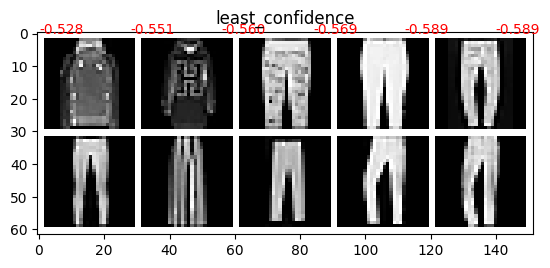

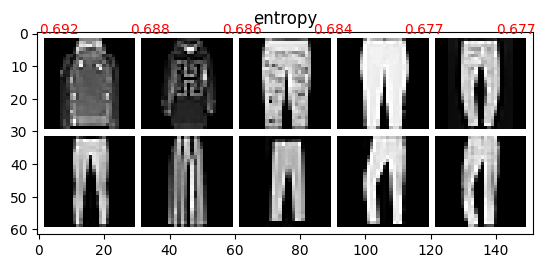

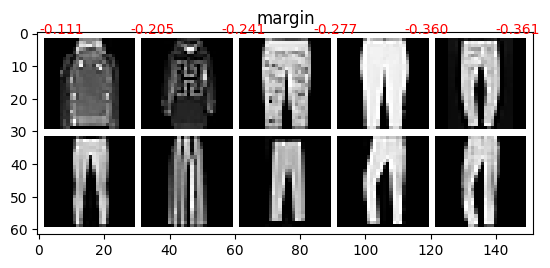

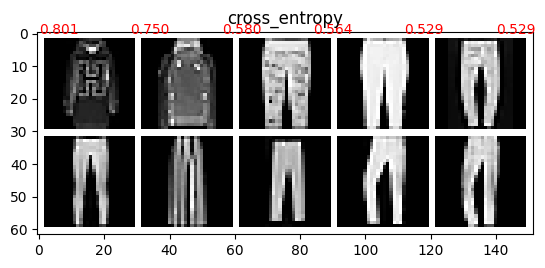

In [16]:
top_k = 10
# for each name, get the top k indices with their scores, plot them annotated with their scores
for name, score in scores.items():
    top_k_idx = score.topk(top_k)[1]
    top_k_scores = score[top_k_idx]
    top_k_images = X_val[top_k_idx]
    top_k_images = top_k_images.view(-1, 1, 28, 28)
    top_k_images = make_grid(top_k_images, nrow=5, padding=2, pad_value=1)
    plt.imshow(top_k_images.cpu().permute(1, 2, 0))
    plt.title(name)
    # annotate the images with their scores
    for i in range(top_k):
        plt.annotate(f"{top_k_scores[i].item():.3f}", (i*28, 0), color='red')
    plt.show()


In [17]:
top_k = 10

agreements = np.zeros((len(scores), len(scores)))
# compute the agreement rate between pairs of scorers
for name1, score1 in scores.items():
    for name2, score2 in scores.items():
        if name1 == name2:
            continue
        # agreement is defined as the size of the intersection of the top k indices
        top_k_idx1 = score1.topk(top_k)[1]
        top_k_idx2 = score2.topk(top_k)[1]
        agreement = len(set(top_k_idx1.tolist()) & set(top_k_idx2.tolist()))
        print(f"{name1} and {name2} agree on >> {agreement} / {top_k} images")
        agreements[list(scores.keys()).index(name1), list(scores.keys()).index(name2)] = agreement

least_confidence and entropy agree on >> 10 / 10 images
least_confidence and margin agree on >> 10 / 10 images
least_confidence and cross_entropy agree on >> 10 / 10 images
entropy and least_confidence agree on >> 10 / 10 images
entropy and margin agree on >> 10 / 10 images
entropy and cross_entropy agree on >> 10 / 10 images
margin and least_confidence agree on >> 10 / 10 images
margin and entropy agree on >> 10 / 10 images
margin and cross_entropy agree on >> 10 / 10 images
cross_entropy and least_confidence agree on >> 10 / 10 images
cross_entropy and entropy agree on >> 10 / 10 images
cross_entropy and margin agree on >> 10 / 10 images


In [18]:
agreements

array([[ 0., 10., 10., 10.],
       [10.,  0., 10., 10.],
       [10., 10.,  0., 10.],
       [10., 10., 10.,  0.]])

In [8]:
# NOTE: somehow cross entropy is not agreeing with anyone??? Might be the case that it is just confidently wrong.

In [9]:
# import torchvision.transforms as transforms

# def resize(img, score):
#     # img.shape = (1, 28, 28) and is a numpy array
#     # score is a float
#     img = torch.tensor(img)
#     trans = transforms.Resize((int(28*score)+5, int(28*score)+5))
#     img = trans(img)
#     return img

# plt.figure(figsize=(20, 10))
# _scores = scores['least_confidence']
# # normalize scores to [0, 1]
# _scores = (_scores - _scores.min()) / (_scores.max() - _scores.min())

# X_val_resized = []
# for img, score in zip(X_val, _scores):
#     X_val_resized.append(resize(img, score)) # [1, h_new, w_new]


# max_h = max([img.shape[1] for img in X_val_resized])
# min_h = min([img.shape[1] for img in X_val_resized])
# print(min_h, max_h)


# # visualize using make_grid
# X_val_resized = [torch.nn.functional.pad(img, (0, max_h-img.shape[1], 0, max_h-img.shape[2])) for img in X_val_resized]
# X_val_resized = torch.stack(X_val_resized)

# from torchvision.utils import make_grid
# grid = make_grid(X_val_resized, nrow=10).cpu()
# plt.imshow(grid.permute(1, 2, 0),)


# plt.figure(figsize=(20, 10))
# _scores = scores['entropy']
# # normalize scores to [0, 1]
# _scores = (_scores - _scores.min()) / (_scores.max() - _scores.min())

# X_val_resized = []
# for img, score in zip(X_val, _scores):
#     X_val_resized.append(resize(img, score)) # [1, h_new, w_new]


# max_h = max([img.shape[1] for img in X_val_resized])
# min_h = min([img.shape[1] for img in X_val_resized])
# print(min_h, max_h)


# # visualize using make_grid
# X_val_resized = [torch.nn.functional.pad(img, (0, max_h-img.shape[1], 0, max_h-img.shape[2])) for img in X_val_resized]
# X_val_resized = torch.stack(X_val_resized)

# from torchvision.utils import make_grid
# grid = make_grid(X_val_resized, nrow=10).cpu()
# plt.imshow(grid.permute(1, 2, 0))
